# Lab 3 CNN 
<p>Desarrollar de forma autónoma distintas implementaciones de redes neuronales profundas de
aprendizaje supervisado que permitan resolver distintos casos de uso. La práctica consiste en
la construcción de un modelo de DNN para clasificación usando redes de convolución.</p>

#### Iñigo Vazquez Alonso 

### Imports

In [1]:
import tensorflow as tf
import keras as ker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Rescaling

### Varibles Globales

In [2]:
num_clases = 10
xpixel = 32
ypixel = 32
batch = 32
epoch = 50
l_rate = 0.001

### Carga de Datos
<p>Para la carga de datos usaremos la funcion load_data y el conjunto de imagenes CIFAR-10 la cual esta compuesta de 10 clases diferentes de imagenes</p>
<a href="https://keras.io/api/datasets/cifar10/">Keras Cifar-10</a>
<p></p>
<table>
  <tr>
    <th>Etiqueta</th>
    <th>Descripcion</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Avion</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Automovil</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Ave</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Gato</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Ciervo</td>
  </tr>
  <tr>
    <td>5</td>
    <td>Perro</td>
  </tr>
  <tr>
    <td>6</td>
    <td>Rana</td>
  </tr>
  <tr>
    <td>7</td>
    <td>Caballo</td>
  </tr>
  <tr>
    <td>8</td>
    <td>Barco</td>
  </tr>
  <tr>
    <td>9</td>
    <td>Camion</td>
  </tr>
</table>

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() #Cargamos los datos directamente
y_train = tf.keras.utils.to_categorical(y_train) # De decimal a binario para poder hacer clasificacion multiple con el MLP
y_test = tf.keras.utils.to_categorical(y_test) # De decimal a binario para poder hacer clasificacion multiple con el MLP

def cargarDatos(): # Por si queremos recargar los datos
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    return x_train,y_train,x_test,y_test

def mostrarimagenes(rango,imgs): # Para imprimir rangoxrango imagenes
    X = imgs # 50 000 Imagenes de 32x32 rgb (32x32x3)
    fig, axes1 = plt.subplots(rango,rango,figsize=(7,7))
    for j in range(rango):
        for k in range(rango):
            i = np.random.choice(range(len(X)))
            axes1[j][k].set_axis_off()
            axes1[j][k].imshow(X[i:i+1][0])

In [4]:
def DatosAug(batch): # por si queremos tener aun mas imagenes usamos augmentation

    train_datagen = ImageDataGenerator(  # Aqui se hacen los cambios a las imagenes
        # Normalizar no hace falta porque aplico una capa de normalizacion en mis modelos
        rotation_range=20, #Rotacion de 20 grados
        horizontal_flip = True,  # Rotacion completa
        validation_split=0.2
    )
    train_generator = train_datagen.flow(
        x_train,
        y_train,
        subset="training",
        batch_size=batch
        )

    validation_generator = train_datagen.flow(
        x_train,
        y_train,
        subset="validation",
        batch_size=batch
        )
        
    return train_generator, validation_generator

### Acontinuacion mostarmos un set de imagenes de CIFAR-10 para ver si esta todo en orden

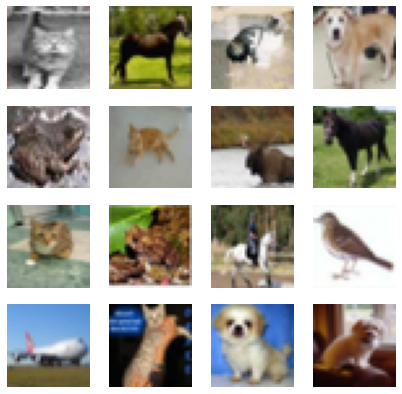

In [5]:
mostrarimagenes(4,x_train)

### Funciones para la creacion y evaluacion de las redes

In [21]:
 # Primero creamos un callback personalizado usando la clase de callback donde por cada epoch coge el loss y lo compara con 0.2 si es menor para el entrenamiento
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs={}): #epoch no se usa dentro de nuestra funcion pero es esencial para que funcione cuando estemos entrenando
        if(logs.get('loss') <= 0.2):
            self.model.stop_training = True

def Entrenar(m, e, v, epo, b): # Funcion para entrenar nuestras redes
    # Para parar segun el criterio de la pr
    elcallback = myCallback()
    history = m.fit(
        e,
        validation_data=v,
        epochs=epo,
        batch_size=b,
        verbose=1,  # Esto te imprime un progress bar con informacion
        shuffle=True, # Da las imagenes aleatorias cada batch es aleatorio
        callbacks= elcallback
    )
    return history

def pintarmodelo(modelo): # Pinta nuestros modelos usando la herramineta de keras
    tf.keras.utils.plot_model(
        modelo,
        to_file='model.png',
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir='TB',
        expand_nested=False,
        dpi=96
    )
    
def MostrarPedicciones(predicciones,Nimg):
   prediccionesNormalizadas = predicciones * 100 # Lo pasamos a %
   DataFramePredicciones = pd.DataFrame(prediccionesNormalizadas, columns = ['Avion','Automovil','Ave','Gato','Ciervo','Perro','Rana','Caballo','Barco','Camion']) # Creamos un dataset
   for row in range(Nimg): # Por cada fila en el rango de imagenes que queramos ver
      x = DataFramePredicciones.iloc[row].sort_values( ascending=False) #ordenamos de mayor a menor
      y = x[:3] # Cogemos los tres primeros valores
      titulo = y.to_string() # los pasamos a string para el titulo
      plt.figure(row,figsize=(2,2))
      plt.imshow(x_test[row])
      plt.axis("off")
      plt.title(titulo)
   

## Red Base

In [7]:
def Modelar_red(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))

    model.add(Conv2D(filters=n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    # capas convolucionales concatenadas
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Epoch 1/50
1250/1250 [==============================] - 22s 16ms/step - loss: 1.5323 - accuracy: 0.4394 - val_loss: 1.3045 - val_accuracy: 0.5363
Epoch 2/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.2073 - accuracy: 0.5673 - val_loss: 1.0854 - val_accuracy: 0.6149
Epoch 3/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0617 - accuracy: 0.6223 - val_loss: 1.0400 - val_accuracy: 0.6303
Epoch 4/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9804 - accuracy: 0.6528 - val_loss: 0.9410 - val_accuracy: 0.6622
Epoch 5/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9129 - accuracy: 0.6785 - val_loss: 0.8771 - val_accuracy: 0.6914
Epoch 6/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.8673 - accuracy: 0.6950 - val_loss: 0.8654 - val_accuracy: 0.6983
Epoch 7/50
1250/1250 [==============================] - 22s 18ms/step - loss: 0.8234 - accuracy: 0.7133 - val_loss: 0.8360 -

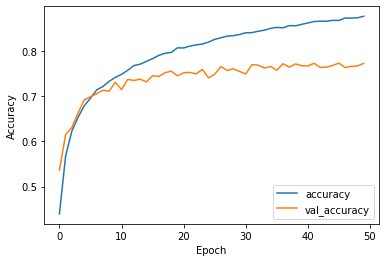

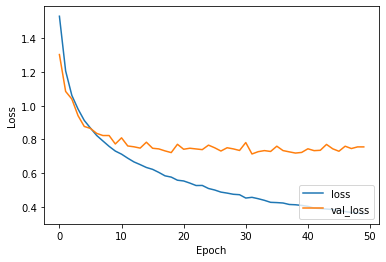

In [8]:
train, validation = DatosAug(batch) # Con Aug
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red(32,64,128,xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Red v1.0

In [9]:
def Modelar_red2(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))

    model.add(Conv2D(filters=n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    # capas convolucionales concatenadas
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Epoch 1/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.5143 - accuracy: 0.4526 - val_loss: 1.2527 - val_accuracy: 0.5463
Epoch 2/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.1672 - accuracy: 0.5837 - val_loss: 1.0413 - val_accuracy: 0.6295
Epoch 3/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.0328 - accuracy: 0.6348 - val_loss: 0.9626 - val_accuracy: 0.6740
Epoch 4/50
1250/1250 [==============================] - 21s 17ms/step - loss: 0.9368 - accuracy: 0.6701 - val_loss: 0.9078 - val_accuracy: 0.6821
Epoch 5/50
1250/1250 [==============================] - 22s 18ms/step - loss: 0.8775 - accuracy: 0.6906 - val_loss: 0.8835 - val_accuracy: 0.6840
Epoch 6/50
1250/1250 [==============================] - 20s 16ms/step - loss: 0.8287 - accuracy: 0.7087 - val_loss: 0.8246 - val_accuracy: 0.7126
Epoch 7/50
1250/1250 [==============================] - 21s 17ms/step - loss: 0.7884 - accuracy: 0.7223 - val_loss: 0.8016 -

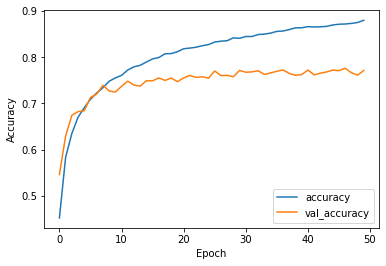

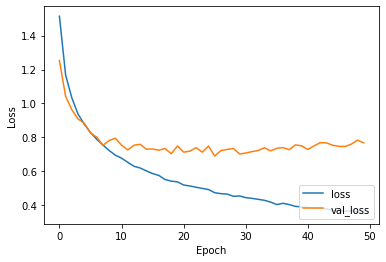

In [13]:
train, validation = DatosAug(batch) # Con Aug
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red2(32,64,128,xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Red v2.0

In [ ]:
def Modelar_red3(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))

    model.add(Conv2D(filters=n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    # capas convolucionales concatenadas
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dropout(0.5))
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Epoch 1/50
1600/1600 [==============================] - 27s 16ms/step - loss: 1.7299 - accuracy: 0.3633 - val_loss: 1.3634 - val_accuracy: 0.4950
Epoch 2/50
1600/1600 [==============================] - 22s 14ms/step - loss: 1.4472 - accuracy: 0.4756 - val_loss: 1.2332 - val_accuracy: 0.5485
Epoch 3/50
1600/1600 [==============================] - 21s 13ms/step - loss: 1.3240 - accuracy: 0.5233 - val_loss: 1.1273 - val_accuracy: 0.5945
Epoch 4/50
1600/1600 [==============================] - 21s 13ms/step - loss: 1.2347 - accuracy: 0.5581 - val_loss: 1.1096 - val_accuracy: 0.6023
Epoch 5/50
1600/1600 [==============================] - 21s 13ms/step - loss: 1.1686 - accuracy: 0.5848 - val_loss: 1.0370 - val_accuracy: 0.6398
Epoch 6/50
1600/1600 [==============================] - 22s 14ms/step - loss: 1.1169 - accuracy: 0.6075 - val_loss: 0.9770 - val_accuracy: 0.6567
Epoch 7/50
1600/1600 [==============================] - 25s 15ms/step - loss: 1.0721 - accuracy: 0.6207 - val_loss: 0.9315 -

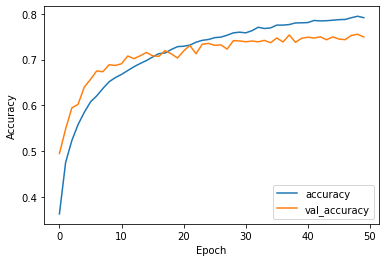

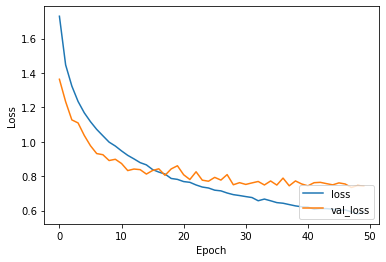

In [ ]:
train, validation = DatosAug(batch) # Con Aug
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red3(32,64,128,xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Red v3.0

In [ ]:
def Modelar_red4(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))
     # capas convolucionales     
    model.add(Conv2D(n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(n_conv1, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same')) 
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))                
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dropout(0.5))
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Epoch 1/150
1600/1600 [==============================] - 25s 15ms/step - loss: 1.7743 - accuracy: 0.3445 - val_loss: 1.4398 - val_accuracy: 0.4721
Epoch 2/150
1600/1600 [==============================] - 24s 15ms/step - loss: 1.4355 - accuracy: 0.4798 - val_loss: 1.2120 - val_accuracy: 0.5534
Epoch 3/150
1600/1600 [==============================] - 26s 16ms/step - loss: 1.2933 - accuracy: 0.5357 - val_loss: 1.1578 - val_accuracy: 0.5805
Epoch 4/150
1600/1600 [==============================] - 27s 17ms/step - loss: 1.2021 - accuracy: 0.5701 - val_loss: 1.0237 - val_accuracy: 0.6365
Epoch 5/150
1600/1600 [==============================] - 28s 18ms/step - loss: 1.1284 - accuracy: 0.6034 - val_loss: 0.9948 - val_accuracy: 0.6398
Epoch 6/150
1600/1600 [==============================] - 25s 16ms/step - loss: 1.0749 - accuracy: 0.6234 - val_loss: 0.9724 - val_accuracy: 0.6594
Epoch 7/150
1600/1600 [==============================] - 28s 17ms/step - loss: 1.0331 - accuracy: 0.6388 - val_loss: 0

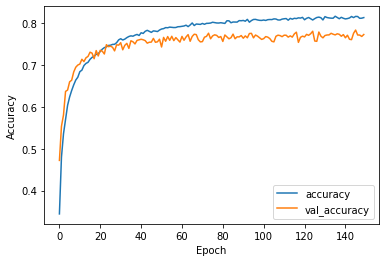

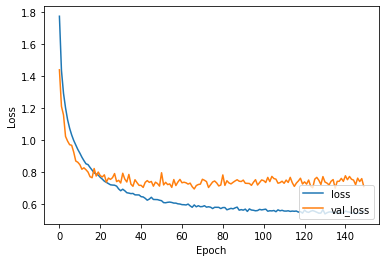

In [ ]:
train, validation = DatosAug(batch) # Con Aug
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red4(32,64,128,xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Red v4.0

In [ ]:
def Modelar_red5(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))
     # capas convolucionales    
    model.add(Conv2D(n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(n_conv1, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same')) 
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))


    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))                
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dropout(0.2))
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Epoch 1/100
1600/1600 [==============================] - 27s 17ms/step - loss: 1.7465 - accuracy: 0.3501 - val_loss: 1.3920 - val_accuracy: 0.4930
Epoch 2/100
1600/1600 [==============================] - 24s 15ms/step - loss: 1.3817 - accuracy: 0.5031 - val_loss: 1.2142 - val_accuracy: 0.5606
Epoch 3/100
1600/1600 [==============================] - 24s 15ms/step - loss: 1.2504 - accuracy: 0.5518 - val_loss: 1.1416 - val_accuracy: 0.5866
Epoch 4/100
1600/1600 [==============================] - 24s 15ms/step - loss: 1.1517 - accuracy: 0.5924 - val_loss: 1.0408 - val_accuracy: 0.6248
Epoch 5/100
1600/1600 [==============================] - 25s 16ms/step - loss: 1.0827 - accuracy: 0.6191 - val_loss: 0.9774 - val_accuracy: 0.6518
Epoch 6/100
1600/1600 [==============================] - 22s 14ms/step - loss: 1.0319 - accuracy: 0.6385 - val_loss: 0.9382 - val_accuracy: 0.6647
Epoch 7/100
1600/1600 [==============================] - 23s 14ms/step - loss: 0.9828 - accuracy: 0.6520 - val_loss: 0

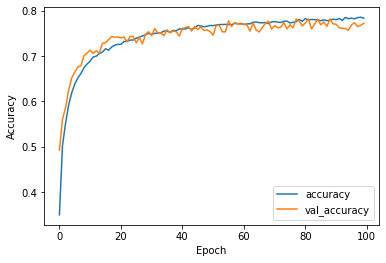

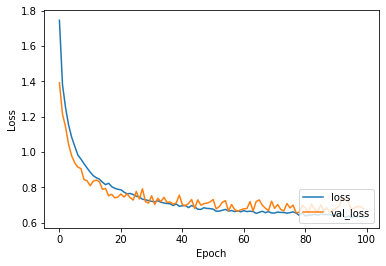

In [ ]:
train, validation = DatosAug(batch) # Con Aug
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red5(32,64,128,xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Red v5.0

In [ ]:
def Modelar_red6(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))
     # capas convolucionales  
    model.add(Conv2D(n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_conv1, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))


    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())                
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dropout(0.2))
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Epoch 1/50
625/625 [==============================] - 21s 33ms/step - loss: 1.6343 - accuracy: 0.4111 - val_loss: 1.3306 - val_accuracy: 0.5249
Epoch 2/50
625/625 [==============================] - 20s 32ms/step - loss: 1.2457 - accuracy: 0.5549 - val_loss: 1.2154 - val_accuracy: 0.5811
Epoch 3/50
625/625 [==============================] - 20s 31ms/step - loss: 1.0707 - accuracy: 0.6245 - val_loss: 0.9739 - val_accuracy: 0.6635
Epoch 4/50
625/625 [==============================] - 20s 32ms/step - loss: 0.9613 - accuracy: 0.6664 - val_loss: 0.8771 - val_accuracy: 0.6920
Epoch 5/50
625/625 [==============================] - 19s 31ms/step - loss: 0.8791 - accuracy: 0.6938 - val_loss: 1.0289 - val_accuracy: 0.6496
Epoch 6/50
625/625 [==============================] - 22s 34ms/step - loss: 0.8278 - accuracy: 0.7141 - val_loss: 0.9786 - val_accuracy: 0.6829
Epoch 7/50
625/625 [==============================] - 24s 39ms/step - loss: 0.7688 - accuracy: 0.7365 - val_loss: 0.7571 - val_accuracy:

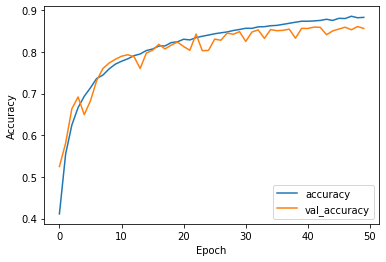

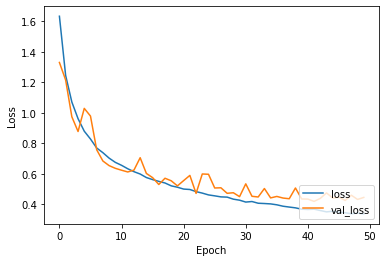

In [ ]:
train, validation = DatosAug(batch) # Con Aug
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red6(32,64,128,xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Red v6.0

In [ ]:
def Modelar_red7(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))
     # capas convolucionales    
    model.add(Conv2D(n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_conv1, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))


    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())                
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dropout(0.2))
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Epoch 1/50
625/625 [==============================] - 19s 29ms/step - loss: 1.6630 - accuracy: 0.4006 - val_loss: 1.4698 - val_accuracy: 0.4614
Epoch 2/50
625/625 [==============================] - 20s 31ms/step - loss: 1.2952 - accuracy: 0.5342 - val_loss: 1.1238 - val_accuracy: 0.5941
Epoch 3/50
625/625 [==============================] - 17s 27ms/step - loss: 1.1232 - accuracy: 0.6009 - val_loss: 0.9607 - val_accuracy: 0.6600
Epoch 4/50
625/625 [==============================] - 17s 28ms/step - loss: 1.0079 - accuracy: 0.6482 - val_loss: 0.9745 - val_accuracy: 0.6541
Epoch 5/50
625/625 [==============================] - 19s 30ms/step - loss: 0.9392 - accuracy: 0.6736 - val_loss: 0.8020 - val_accuracy: 0.7201
Epoch 6/50
625/625 [==============================] - 18s 28ms/step - loss: 0.8817 - accuracy: 0.6944 - val_loss: 0.7505 - val_accuracy: 0.7392
Epoch 7/50
625/625 [==============================] - 19s 30ms/step - loss: 0.8243 - accuracy: 0.7163 - val_loss: 0.9165 - val_accuracy:

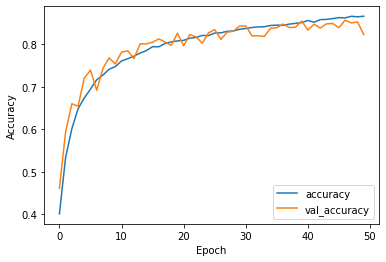

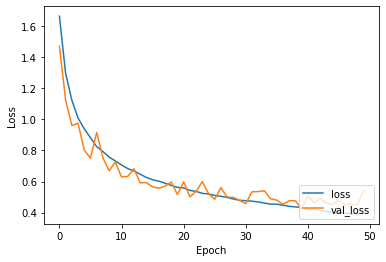

In [ ]:
train, validation = DatosAug(batch) # Con Aug
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red7(32,64,128,xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Red v6.0 con diferentes learning rates

## Lr = 0.0001

Epoch 1/150
625/625 [==============================] - 19s 30ms/step - loss: 2.2322 - accuracy: 0.2325 - val_loss: 2.1152 - val_accuracy: 0.2696
Epoch 2/150
625/625 [==============================] - 18s 29ms/step - loss: 1.7814 - accuracy: 0.3452 - val_loss: 1.5672 - val_accuracy: 0.4335
Epoch 3/150
625/625 [==============================] - 19s 30ms/step - loss: 1.6383 - accuracy: 0.4044 - val_loss: 1.4758 - val_accuracy: 0.4700
Epoch 4/150
625/625 [==============================] - 19s 31ms/step - loss: 1.5454 - accuracy: 0.4424 - val_loss: 1.4590 - val_accuracy: 0.4824
Epoch 5/150
625/625 [==============================] - 19s 31ms/step - loss: 1.4712 - accuracy: 0.4718 - val_loss: 1.4213 - val_accuracy: 0.4980
Epoch 6/150
625/625 [==============================] - 19s 31ms/step - loss: 1.3995 - accuracy: 0.4954 - val_loss: 1.5708 - val_accuracy: 0.4803
Epoch 7/150
625/625 [==============================] - 19s 31ms/step - loss: 1.3355 - accuracy: 0.5256 - val_loss: 1.4358 - val_ac

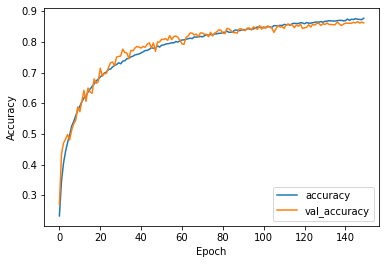

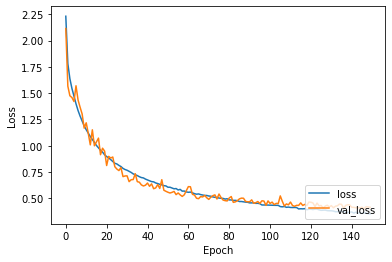

In [ ]:
train, validation = DatosAug(batch) # Con Aug
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red7(32,64,128,xpixel, ypixel, 0.0001)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation,150, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Lr = 0.00001

Epoch 1/250
625/625 [==============================] - 20s 31ms/step - loss: 3.5720 - accuracy: 0.1358 - val_loss: 2.3125 - val_accuracy: 0.1715
Epoch 2/250
625/625 [==============================] - 19s 31ms/step - loss: 2.4540 - accuracy: 0.1807 - val_loss: 2.0367 - val_accuracy: 0.2510
Epoch 3/250
625/625 [==============================] - 19s 31ms/step - loss: 2.2172 - accuracy: 0.2061 - val_loss: 1.9900 - val_accuracy: 0.2721
Epoch 4/250
625/625 [==============================] - 19s 31ms/step - loss: 2.1351 - accuracy: 0.2192 - val_loss: 1.9432 - val_accuracy: 0.2944
Epoch 5/250
625/625 [==============================] - 19s 31ms/step - loss: 2.0659 - accuracy: 0.2453 - val_loss: 1.8906 - val_accuracy: 0.3162
Epoch 6/250
625/625 [==============================] - 20s 31ms/step - loss: 2.0136 - accuracy: 0.2643 - val_loss: 1.8557 - val_accuracy: 0.3375
Epoch 7/250
625/625 [==============================] - 19s 31ms/step - loss: 1.9605 - accuracy: 0.2825 - val_loss: 1.8221 - val_ac

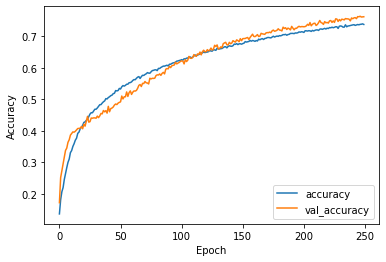

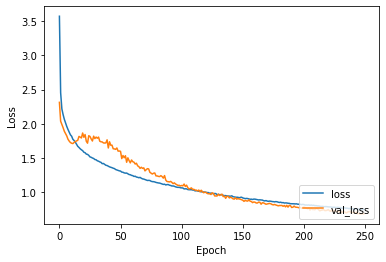

In [ ]:
train, validation = DatosAug(batch) # Con Aug
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red7(32,64,128,xpixel, ypixel, 0.00001)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, 250 , batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Red v7.0

In [8]:
def Modelar_red8(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))
     # capas convolucionales 
    model.add(Conv2D(n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_conv1, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))


    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())                
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dropout(0.5))
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Epoch 1/100
1250/1250 [==============================] - 28s 19ms/step - loss: 1.9442 - accuracy: 0.2788 - val_loss: 1.4712 - val_accuracy: 0.4523
Epoch 2/100
1250/1250 [==============================] - 26s 21ms/step - loss: 1.5732 - accuracy: 0.4236 - val_loss: 1.2773 - val_accuracy: 0.5415
Epoch 3/100
1250/1250 [==============================] - 22s 18ms/step - loss: 1.3887 - accuracy: 0.4984 - val_loss: 1.1263 - val_accuracy: 0.6021
Epoch 4/100
1250/1250 [==============================] - 22s 17ms/step - loss: 1.2432 - accuracy: 0.5632 - val_loss: 1.0706 - val_accuracy: 0.6230
Epoch 5/100
1250/1250 [==============================] - 22s 17ms/step - loss: 1.1349 - accuracy: 0.6120 - val_loss: 0.9713 - val_accuracy: 0.6616
Epoch 6/100
1250/1250 [==============================] - 22s 18ms/step - loss: 1.0489 - accuracy: 0.6418 - val_loss: 0.8963 - val_accuracy: 0.6846
Epoch 7/100
1250/1250 [==============================] - 22s 17ms/step - loss: 0.9849 - accuracy: 0.6698 - val_loss: 0

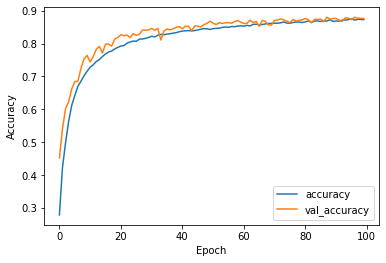

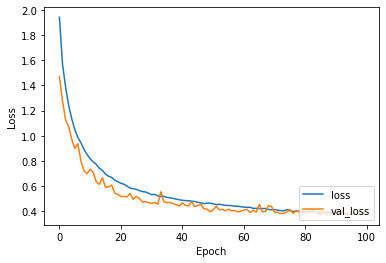

In [9]:
train, validation = DatosAug(batch) # Con Aug
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red8(32,64,128,xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, 100 , batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Learning rate 0.0001 y Batch 64

Epoch 1/150
1250/1250 [==============================] - 28s 21ms/step - loss: 2.1845 - accuracy: 0.2282 - val_loss: 1.7496 - val_accuracy: 0.3676
Epoch 2/150
1250/1250 [==============================] - 25s 20ms/step - loss: 1.7920 - accuracy: 0.3458 - val_loss: 1.6864 - val_accuracy: 0.4042
Epoch 3/150
1250/1250 [==============================] - 28s 22ms/step - loss: 1.6519 - accuracy: 0.4020 - val_loss: 1.5173 - val_accuracy: 0.4647
Epoch 4/150
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5536 - accuracy: 0.4427 - val_loss: 1.4431 - val_accuracy: 0.4863
Epoch 5/150
1250/1250 [==============================] - 23s 19ms/step - loss: 1.4747 - accuracy: 0.4740 - val_loss: 1.3720 - val_accuracy: 0.5239
Epoch 6/150
1250/1250 [==============================] - 25s 20ms/step - loss: 1.3879 - accuracy: 0.5059 - val_loss: 1.3177 - val_accuracy: 0.5285
Epoch 7/150
1250/1250 [==============================] - 26s 21ms/step - loss: 1.3272 - accuracy: 0.5303 - val_loss: 1

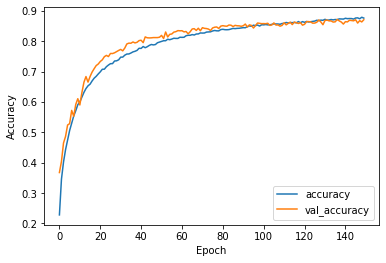

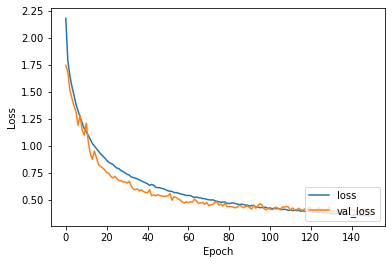

In [10]:
train, validation = DatosAug(batch) # Con Aug
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red8(32,64,128,xpixel, ypixel, 0.0001)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, 150 , 64)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## Evaluamos el modelo final con el data set de prueba

In [10]:
model.evaluate(x_test,y_test) # Evaluammos las imagenes de prueba

313/313 [==============================] - 2s 7ms/step - loss: 0.4169 - accuracy: 0.8707


[0.41685596108436584, 0.8707000017166138]

## Predictor

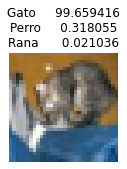

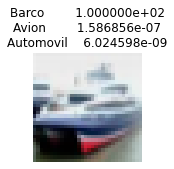

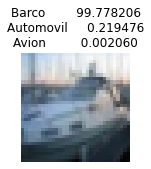

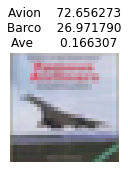

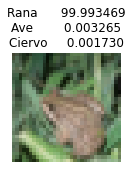

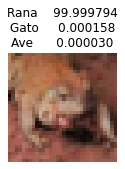

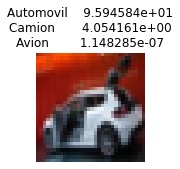

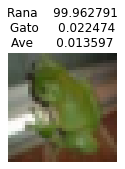

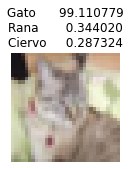

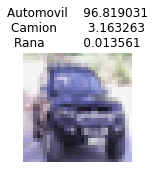

In [22]:
predicciones = model.predict(x_test)
MostrarPedicciones(predicciones , 10) # Muestro solo 10 imagenes 